### covid-19 JH data trends<br>
author   : santosh<br>
date     : 05.01.2020<br>
purpose  : ingest covid-19 data, reformat and generate country level trends<br>
instance : local<br>

<font color='tan'> setup

In [15]:
#import dependencies
#data wrangling
import numpy as np
import pandas as pd
import dfply as dfp
import datetime as dt
#plot
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sb
#helper funcs
from helper_funcs import isUnique

In [16]:
#display options
pd.options.display.html.table_schema = True
pd.set_option('display.max_rows', 999)
%matplotlib inline

<font color='tan'> ingest data

In [17]:
#func to read csv file
def ingestJH(ipfilename, colname):
    """
    this func ingests JH covid-19 data and returns a scrubbed dataframe
    """
    #read csv and drop 1st row
    df = pd.read_csv(ipfilename, sep=',',skiprows=0, parse_dates=['Date'])
    df.drop(index=0, axis=0, inplace=True)
    
    #scrub fields
    df.rename(columns={'Country/Region':'Country_Region',
                       'Province/State':'Province_State',
                       'Value':colname,
                       'ISO 3166-1 Alpha 3-Codes':'ISO3166-1Alpha3-Codes',
                       'Region Code':'Region_Code',
                       'Sub-region Code':'Sub_Region_Code',
                       'Intermediate Region Code':'Intermediate_Region_Code'}, inplace=True)
    
    #recast data types
    df['Date']  = pd.to_datetime(df['Date'], errors='coerce')
    df['Lat']   = pd.to_numeric(df['Lat'],   errors='coerce')
    df['Long']  = pd.to_numeric(df['Long'],  errors='coerce')
    df[colname] = pd.to_numeric(df[colname], errors='coerce')
    
    #make country value uppercase
    df['Country_Region'] = df['Country_Region'].apply(lambda x:x.upper())
    
    #aggregate across country
    df = df.groupby(['Country_Region','Date']).agg({colname:'sum'}).reset_index()
    print('\nisData Unique in Country and Date: \n')
    print(isUnique(df, ['Country_Region','Date']))
    
    #return df
    return df

In [18]:
df_confirmed = ingestJH('../data/time_series_covid19_confirmed_global_narrow.csv','Confirmed')
df_deaths = ingestJH('../data/time_series_covid19_deaths_global_narrow.csv','Deaths')
df_recovered = ingestJH('../data/time_series_covid19_recovered_global_narrow.csv','Recovered')


isData Unique in Country and Date: 

True

isData Unique in Country and Date: 

True

isData Unique in Country and Date: 

True


In [19]:
#merge confirmed, deaths and recovered data into a single dataframe
df_all = pd.merge(df_confirmed,
                  df_deaths,
                  on=['Country_Region','Date'],
                  how='left',
                  indicator=False)

df_all = pd.merge(df_all,
                  df_recovered,
                  on=['Country_Region','Date'],
                  how='left',indicator=False)

In [20]:
#print sample recs
df_all.loc[df_all['Country_Region'] == 'US'].tail()

,Country_Region,Date,Confirmed,Deaths,Recovered
16456,US,2020-04-19,758809,40661,70337
16457,US,2020-04-20,784326,42094,72329
16458,US,2020-04-21,811865,44444,75204
16459,US,2020-04-22,840351,46622,77366
16460,US,2020-04-23,869170,49954,80203


In [21]:
#get list of all countries in dataframe
list_country = df_all['Country_Region'].unique().tolist()
print('\nnumber of unique countries in list: ', len(list_country))


number of unique countries in list:  185


<font color='tan'> append lagged values

In [22]:
#func to append lag of infusion counts
def getLagValues(country):
    """
    this func appends lagged cumulative infusion counts
    for an input list of countries supplied
    """
    #filter for required country
    stack = df_all.loc[df_all['Country_Region'] == country][['Country_Region','Date',
                                                                     'Confirmed','Deaths',
                                                                     'Recovered']].sort_values(by=['Date'], ascending=True)
    #check for uniqueness
    bool_check = isUnique(stack, ['Date'])
    if bool_check == False:
        print('\naborted due to uniqueness check fail: ', country)
        stop
    else:
        pass
    
    #append lag of cum_inf_count
    stack['Confirmed_Lag'] = stack['Confirmed'].shift(1)
    stack['Deaths_Lag']    = stack['Deaths'].shift(1)
    stack['Recovered_Lag'] = stack['Recovered'].shift(1)
    
    #compute new cases
    stack['Confirmed_New'] = (stack['Confirmed'] - stack['Confirmed_Lag'])
    stack['Confirmed_New'].fillna(0, inplace=True)
    stack['Deaths_New'] = (stack['Deaths'] - stack['Deaths_Lag'])
    stack['Deaths_New'].fillna(0, inplace=True)
    stack['Recovered_New'] = (stack['Recovered'] - stack['Recovered_Lag'])
    stack['Recovered_New'].fillna(0, inplace=True)
    #drop unwanted cols
    stack.drop(columns=['Confirmed_Lag','Deaths_Lag','Recovered_Lag'], inplace=True)
    
    #return data
    return stack

In [25]:
#run lag func for all countries
df_final = pd.DataFrame() #empty dataframe

#iterate over country list
for item in list_country:
    temp = getLagValues(item)
    df_final = pd.concat([df_final, temp], axis=0, sort=True)

In [26]:
df_final.head()

,Confirmed,Confirmed_New,Country_Region,Date,Deaths,Deaths_New,Recovered,Recovered_New
0,0,0.0,AFGHANISTAN,2020-01-22,0,0.0,0,0.0
1,0,0.0,AFGHANISTAN,2020-01-23,0,0.0,0,0.0
2,0,0.0,AFGHANISTAN,2020-01-24,0,0.0,0,0.0
3,0,0.0,AFGHANISTAN,2020-01-25,0,0.0,0,0.0
4,0,0.0,AFGHANISTAN,2020-01-26,0,0.0,0,0.0


<font color='tan'> plot cumulative trends

Choose the metric you want ('Confirmed','Deaths' or 'Recovered')Confirmed


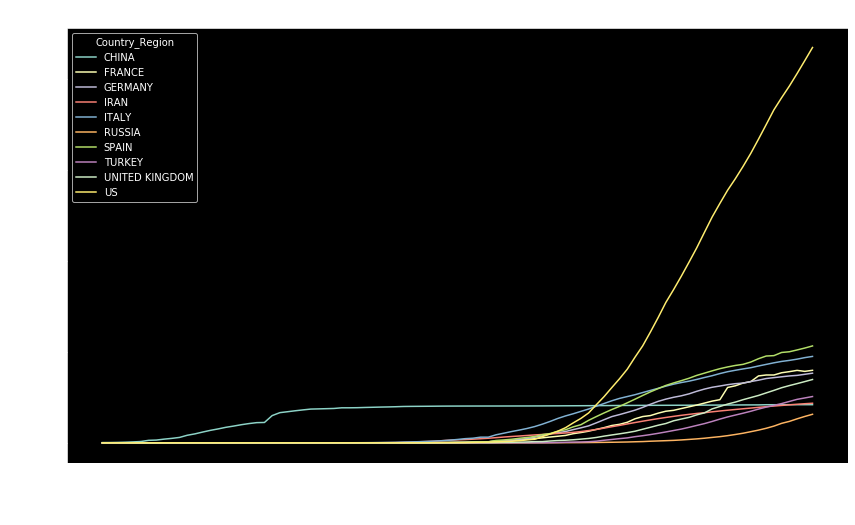

In [51]:
#user selections
metric = input("Choose the metric you want ('Confirmed','Deaths' or 'Recovered')")
list_sel = top_10 # choose 'top_10' or 'top_10_xus'

#list of top 10 countries including US
top_10 = df_final.groupby(['Country_Region'],as_index=False)\
.agg({metric:'max'})\
.sort_values(by=[metric], ascending=False)\
.head(10)['Country_Region']\
.tolist()

#list of top 10 countries excluding US
top_10_xus = df_final.loc[df_final['Country_Region'] != 'US']\
.groupby(['Country_Region'],as_index=False)\
.agg({metric:'max'})\
.sort_values(by=[metric], ascending=False)\
.head(10)['Country_Region']\
.tolist()

#filter and transpose data
p_df = df_final.loc[df_final['Country_Region'].isin(list_sel)]\
.pivot_table(values=metric, index=['Date'], columns='Country_Region')\
.reset_index().fillna(0)
p_df.set_index('Date', inplace=True)

#plot
p_df.plot.line(figsize=(14,8))
plt.title('Cumulative Covid-19 trends: '+metric, size=20)
plt.xlabel('Date',size=14)
plt.xticks(size=14, color='white')
plt.yticks(size=14, color='white')
plt.show()

<font color='tan'> plot daily trends

Choose the metric you want ('Confirmed_New','Deaths_New' or 'Recovered_New')Confirmed_New


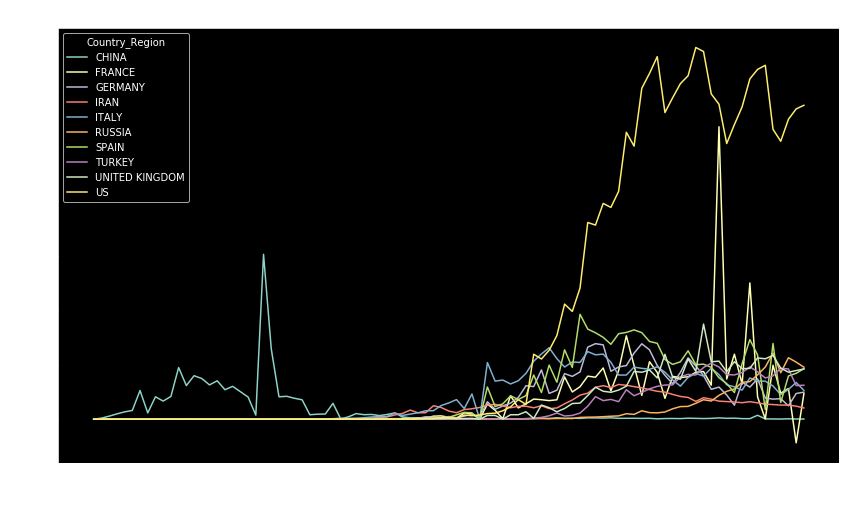

In [52]:
#user selections
metric = input("Choose the metric you want ('Confirmed_New','Deaths_New' or 'Recovered_New')")
list_sel = top_10 # choose 'top_10' or 'top_10_xus'

#filter and transpose data
p_df = df_final.loc[df_final['Country_Region'].isin(list_sel)]\
.pivot_table(values=metric, index=['Date'], columns='Country_Region')\
.reset_index().fillna(0)
p_df.set_index('Date', inplace=True)

#plot
p_df.plot.line(figsize=(14,8))
plt.title('Daily Covid-19 trends: '+metric, size=20)
plt.xlabel('Date',size=14)
plt.xticks(size=14, color='white')
plt.yticks(size=14, color='white')
plt.show()

<font color='tan'> end